In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Network stuff

## IP config

In [ ]:
# ip config
import netifaces
def main():
    #print(netifaces.interfaces())

    for i in netifaces.interfaces():
        try:
            # Address
            print("interface: ", i)
            print("IPv4: ", netifaces.ifaddresses(i)[netifaces.AF_INET][0]['addr'])
            print("IPv6: ", netifaces.ifaddresses('{895B4C84-665C-4F54-8583-164E8FCE1E85}')[23][0]['addr'])
            print("Mask: ", netifaces.ifaddresses(i)[netifaces.AF_INET][0]['netmask'])
            print("Gateway: ", netifaces.gateways()['default'][netifaces.AF_INET][0])
            print("broadcast: ", netifaces.ifaddresses(i)[netifaces.AF_INET][0]['broadcast'])
            #print("interface2: ", netifaces.ifaddresses(i)) # all of it but no presentation
            print("\n")
            
        except:pass

main()

## trace rout

In [ ]:
import scapy.layers.inet as sli
result, unans = sli.traceroute('8.8.8.8', maxttl=30)
print('snd.ttl', '\t','rcv.src', 'snd.sent_time', 'rcv.time')
for snd, rcv in result:   
    print(snd.ttl,'\t', rcv.src,'\t', snd.sent_time,'\t', rcv.time)

# Get data from HTML websites

## wikipedia

In [69]:
# imports
from bs4 import BeautifulSoup
import requests

In [ ]:
url="https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)"

html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "lxml")

In [85]:
print(soup.title.text)

List of countries by GDP (nominal) - Wikipedia


In [86]:
#for link in soup.find_all("a"):
#    print("Inner Text: {}".format(link.text))
#    print("Title: {}".format(link.get("title")))
#    print("href: {}".format(link.get("href")))

In [98]:
gdp_table = soup.find("table", attrs={"class": "wikitable"})
gdp_table_data = gdp_table.tbody.find_all("tr")  # contains 2 rows

# Get all the headings of Lists
headings = []
for td in gdp_table_data[0].find_all("td"):
    # remove any newlines and extra spaces from left and right
    headings.append(td.b.text.replace('\n', ' ').strip())

print(headings)

['Per the International Monetary Fund (2019 estimates)', 'Per the World Bank (2018)', 'Per the United Nations (2017)']


In [108]:
data = {}
for table, heading in zip(gdp_table_data[1].find_all("table"), headings):
    # Get headers of table i.e., Rank, Country, GDP.
    t_headers = []
    for th in table.find_all("th"):
        # remove any newlines and extra spaces from left and right
        t_headers.append(th.text.replace('\n', ' ').strip())
    # Get all the rows of table
    table_data = []
    for tr in table.tbody.find_all("tr"): # find all tr's from table's tbody
        t_row = {}
        # Each table row is stored in the form of
        # t_row = {'Rank': '', 'Country/Territory': '', 'GDP(US$million)': ''}

        # find all td's(3) in tr and zip it with t_header
        for td, th in zip(tr.find_all("td"), t_headers): 
            t_row[th] = td.text.replace('\n', '').strip()
        table_data.append(t_row)

    # Put the data for the table with his heading.
    data[heading] = table_data

#print(data)
print(data['Per the International Monetary Fund (2019 estimates)'][2])

{'Rank': '1', 'Country/Territory': 'United States', 'GDP(US$million)': '21,439,453'}


# request and BeautifulSoup

In [1]:
# imports
from bs4 import BeautifulSoup
import requests

In [130]:
url='http://130.149.129.167/plc/webvisu.htm'

html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "html.parser")
print('TITLE : ',soup.title.text)
print(1*'\n')
print('FILE :\n',soup.prettify())

TITLE :  CoDeSys WebVisualization


FILE :
 <html>
 <head>
  <title>
   CoDeSys WebVisualization
  </title>
  <style type="text/css">
   /******* basic tags *******/
	body
	{
  		margin: 0;
  		padding: 0;
	}
  </style>
 </head>
 <body>
  <applet code="webvisu/WebVisu.class" codebase="." height="100%" id="webvisuapplet" name="WebVisu" width="100%">
   <param name="archive" value="webvisu.jar,minml.jar"/>
   <param name="STARTVISU" value="PLC_VISU"/>
   <param name="UPDATETIME" value="100"/>
   <param name="USECURRENTVISU" value="FALSE"/>
   <param name="USEFIXSOCKETCONNECTION" value="FALSE"/>
   <param name="USEURLCONNECTION" value="FALSE"/>
   <param name="COMPRESSEDFILES" value="TRUE"/>
  </applet>
 </body>
</html>



# with FTP

In [167]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [170]:
from ftplib import FTP
# https://pythonprogramming.net/ftp-transfers-python-ftplib/

#domain name or server ip:
ftp = FTP('130.149.129.167')

#credentials
user = 'admin'
passwd = '***'

#login
ftp.login(user=user, passwd = passwd)

#change current working directory
ftp.cwd('s:')

#get file names
file_names=[]
ftp.dir(file_names.append)

# remoove unecessary infos
file_name_short=[]
for fn in file_names:
    file=fn.split()[-1]
    if file.endswith('.csv'):
        file_name_short.append(file)

# grab files
def grabFile():
 
    localfile = open('data.csv', 'wb')
    for file in file_name_short:
        ftp.retrbinary('RETR ' + file, localfile.write, 1024)

    ftp.quit()
    localfile.close()
    
grabFile()     

# close FTP connection
ftp.close()

In [171]:
#import df
df=pd.read_csv('data.csv',encoding='latin1',usecols=['No.','Date','Time','T1_Cal','T2_Cal'])

#remove the header that is created every day
index_remove = [x - 1 for x in list(df.loc[df['No.']=='1',:].index)[1:]]
df.drop(index_remove,inplace=True)

#reset index
df.reset_index(inplace=True)

#create timestamp
df['DateTime']=df['Date']+' '+ df['Time']
df['DateTime']=pd.to_datetime(df.DateTime, format="%d.%m.%Y %H:%M:%S")

#drop unecessary stuff
df.drop(['No.','index','Date','Time'],axis=1,inplace=True)

#convert T1_Cal and T2_Cal as float
df[['T1_Cal','T2_Cal']] = df[['T1_Cal','T2_Cal']].astype(float)

<IPython.core.display.Javascript object>


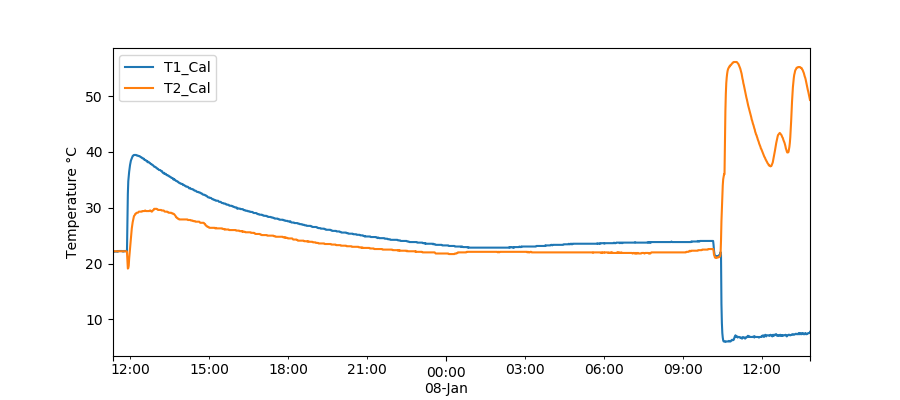

In [185]:
#plot result
%matplotlib notebook
df.set_index('DateTime').iloc[:].plot(figsize=(9,4))
plt.ylabel('Temperature °C')
plt.xlabel('DateTime')
plt.show()

# FTP from Pandas

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request as ur

In [ ]:

# retrieve only the header column & set dtype to save some memory
refseq_summary = "ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/assembly_summary_refseq.txt"
req = ur.Request(refseq_summary)
z_f = ur.urlopen(req)
col_names = pd.read_csv(z_f, sep='\t', nrows=0, skiprows=1)